In [12]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [13]:
# Load embeddings and labels
bert_train1 = np.load("bert_train.npy")
bert_val1 = np.load("bert_val.npy")
bert_test1 = np.load("bert_test.npy")

roberta_train1 = np.load("roberta_train.npy")
roberta_val1 = np.load("roberta_val.npy")
roberta_test1 = np.load("roberta_test.npy")

xlnet_train1 = np.load("xlnet_train.npy")
xlnet_val1 = np.load("xlnet_val.npy")
xlnet_test1 = np.load("xlnet_test.npy")

y_train1 = np.load("y_train.npy")
y_val1 = np.load("y_val.npy")
y_test1 = np.load("y_test.npy")

In [ ]:
#                                                                    -----------------------------  MODEL 1  ----------------------------------

# Concatenate embeddings from all models
X_train = np.concatenate((bert_train1, roberta_train1, xlnet_train1), axis=1)
X_val = np.concatenate((bert_val1, roberta_val1, xlnet_val1), axis=1)
X_test = np.concatenate((bert_test1, roberta_test1, xlnet_test1), axis=1)

class StackingNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(StackingNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 768)  
        self.bn1 = nn.BatchNorm1d(768)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(768, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(256, num_classes)  # Output layer
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)  # No activation for output layer (CrossEntropyLoss expects raw logits)
        return x
    

# Model Initialization
input_dim = X_train.shape[1]
num_labels = 6
model = StackingNN(input_dim, num_labels)

# Define Loss & Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

Epoch [1/60], Train Loss: 1.3331, Val Loss: 1.4426
Epoch [2/60], Train Loss: 0.6435, Val Loss: 0.9927
Epoch [3/60], Train Loss: 0.4358, Val Loss: 0.6245
Epoch [4/60], Train Loss: 0.3410, Val Loss: 0.4130
Epoch [5/60], Train Loss: 0.2851, Val Loss: 0.3102
Epoch [6/60], Train Loss: 0.2471, Val Loss: 0.2614
Epoch [7/60], Train Loss: 0.2219, Val Loss: 0.2375
Epoch [8/60], Train Loss: 0.2022, Val Loss: 0.2243
Epoch [9/60], Train Loss: 0.1881, Val Loss: 0.2162
Epoch [10/60], Train Loss: 0.1770, Val Loss: 0.2103
Epoch [11/60], Train Loss: 0.1674, Val Loss: 0.2056
Epoch [12/60], Train Loss: 0.1605, Val Loss: 0.2014
Epoch [13/60], Train Loss: 0.1552, Val Loss: 0.1975
Epoch [14/60], Train Loss: 0.1500, Val Loss: 0.1942
Epoch [15/60], Train Loss: 0.1443, Val Loss: 0.1910
Epoch [16/60], Train Loss: 0.1415, Val Loss: 0.1881
Epoch [17/60], Train Loss: 0.1379, Val Loss: 0.1852
Epoch [18/60], Train Loss: 0.1339, Val Loss: 0.1829
Epoch [19/60], Train Loss: 0.1300, Val Loss: 0.1809
Epoch [20/60], Train 

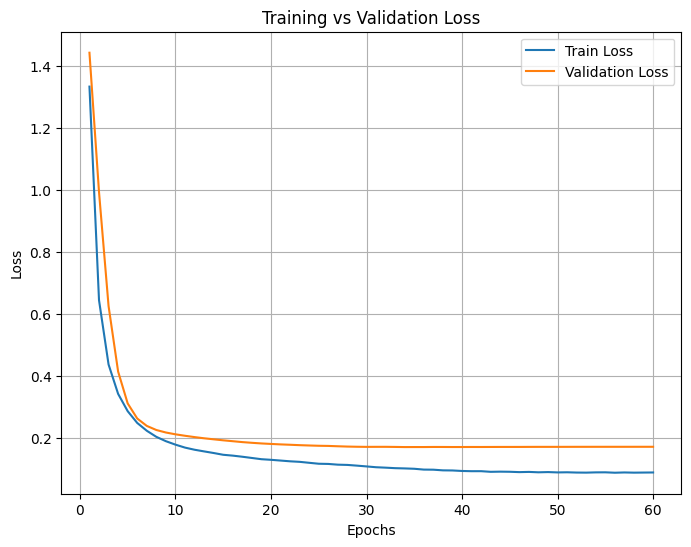

In [15]:

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train1, dtype=torch.long)
y_val_tensor = torch.tensor(y_val1, dtype=torch.long)

train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=4096, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=4096, shuffle=False)

# Early stopping parameters
best_val_loss = float("inf")
patience = 30
counter = 0
epochs = 60

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train, total_train = 0, 0  # Track training accuracy
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    # Compute average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    correct_val, total_val = 0, 0  # Track validation accuracy
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            # Compute validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    # Compute average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Step the scheduler
    scheduler.step(avg_val_loss)
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, "best_model.pth")  # Save best model
        counter = 0  # Reset counter
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break


# Convert test set to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test1, dtype=torch.long)

classifier2 = torch.load("best_model.pth",weights_only=False)
# Get Predictions
classifier2.eval()
with torch.no_grad():
    outputs = classifier2(X_test_tensor)
    _, preds = torch.max(outputs, 1)

# Convert tensors to NumPy arrays
y_test_np = y_test_tensor.numpy()
preds_np = preds.numpy()
report_model1 = classification_report(y_test_np, preds_np, digits=4,output_dict=True)

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [16]:
with open("classification_report_model_1.txt", "r") as f:
    report_content = f.read()
    print(report_content)

              precision    recall  f1-score   support

           0     0.9675    0.9669    0.9672       581
           1     0.9498    0.9481    0.9489       695
           2     0.8701    0.8654    0.8677       159
           3     0.9361    0.9355    0.9358       275
           4     0.9316    0.9321    0.9318       224
           5     0.8224    0.8431    0.8326        66

    accuracy                         0.9401      2000
   macro avg     0.9129    0.9152    0.9140      2000
weighted avg     0.9405    0.9400    0.9402      2000

